------------------
### ★ Maching Learning 기본 순서 ★
1. **전체 dataset을 불러옴 (데이터를 모음)**
2. **traing set / test set으로 나눔**
3. **빈 모델을 만듦** 이진분류: DecisionTreeClassifier()  / RadomForestClassifier() 등
4. **빈 모델에 traing set을 넣어 모델을 학습시킴** .fit()  
5. **학습된 모델에 test set을 넣어 예측시켜봄** .predict()
6. **잘 풀었나 채점해봄** .precision_score() .recall_score() . f1_score()
------------

# <span style="color:blue">13주차(2) Random Forest - Classification</span>
Discriminating drugs ans non-drugs using Random Forest

♤ QSAR 화학 예측 모델 - Classification ♤  
이 내용에 익숙해 지면 제약회사에서 데이터 분석을 할 수 있음!
## 수업 목표: 실제 약 분자와 약이 아닌 분자를 구별(Classification) 하는 AI (machine, model)을 만들어보자. 

In [1]:
import numpy as np 
import sklearn

In [5]:
import rdkit 
import rdkit.Chem as Chem

In [3]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

------------------
### ★ Maching Learning 기본 순서 ★
1. **전체 dataset을 불러옴 (데이터를 모음)**
2. traing set / test set으로 나눔
3. 빈 모델을 만듦 sklearn.tree.DecisionTreeClassifier() / .RandomForestClassifier() 등
4. 빈 모델에 traing set을 넣어 모델을 학습시킴 .fit()  
5. 학습된 모델에 test set을 넣어 예측시켜봄 .predict()
6. 잘 풀었나 채점해봄 .precision_score() .recall_score() . f1_score()
------------

* drugs.smi -> 실제 시판되고 있는 약 분자 600개의 SMILES 가 들어있다. 
* non_drugs.smi -> 랜덤하게 DB에서 고른 분자 1000 개의 SMILES가 들어있다. 

# [1] 약 분자들의 property가 들어있는 dataframe을 만들자!
## 1. drug.smi로 분자를 읽어들이자! -> 리스트에 저장!

In [6]:
drugs = [] # 빈 리스트 준비. 
with open("drugs.smi") as fp:
    for l in fp:
        smiles = l.strip()
        mol = Chem.MolFromSmiles(smiles) # smiles를 rdkit의 Mol 타입으로 변환. 
        if mol: # 변환에 문제가 있으면, mol에 None이 들어있게 된다. None은 조건문에서 False에 해당. 
            # 분자가 제대로 변환이 되었다. 
            drugs.append(mol)

In [7]:
len(drugs)

600

* ↑ drugs 리스트 안에는 600개가 들어있다.

In [8]:
drugs # Mol 타입 600개가 들어있다. 

## 2.분자로 부터 
## 분자의 특성(feature)를 뽑아내 딕셔너리에 넣은 후
## pandas DataFrame으로 변환하자!

* 분자의 특징을 나타내는 여러가지 변수: molecular descriptor (분자 표현자)
* 예시) 1. 분자량 2. 탄소의 개수 3. 질소의 개수 4. 산소의 개수, 5. 수소결합 받개의 개수, 6. 단일 결합의 개수, 7. 고리의 개수..... 
* descriptor는 rdkit으로 계산이 가능하다. 
* 전체 descriptor의 목록: https://www.rdkit.org/docs/source/rdkit.Chem.rdMolDescriptors.html

### drug molecule 특징 중 유명한 규칙  Linpinski's rule of five. 
* https://en.wikipedia.org/wiki/Lipinski%27s_rule_of_five#:~:text=Lipinski's%20rule%20states%20that%2C%20in,all%20nitrogen%20or%20oxygen%20atoms)
1. 수소결합 받개의 개수 < 10  ---(HBD : O, N에 붙어있는 H (OH,NH)
2. 수소결합 주개의 개수 < 5   ---(HBA : lone pair를 가지고 있는 N,O등)
3. 분자량 < 500 Dalton
4. logP < 5

* Descriptor 계산을 위한 모듈을 불러오자. 

In [9]:
import rdkit.Chem.rdMolDescriptors 

* rdkit.Chem.rdMolDescriptors.CalcExactMolWt 이렇게 불러오는 것은 불편하므로... 

In [11]:
from rdkit.Chem.rdMolDescriptors import CalcExactMolWt, CalcNumLipinskiHBA, CalcNumLipinskiHBD, CalcCrippenDescriptors

### ◎분자들의 물성(property)을 계산한 값을 넣은 딕셔너리를 생성!

In [16]:
# descriptor (분자의 property) 들을 feature로 쓸 것이다.
# descriptor를 저장할 딕셔너리를 초기화 하자. (빈 딕셔너리를 생성하자.)

# 만든 딕셔너리를 pands의 dataframe (엑셀 형식)으로 변환 킬 것이기 때문에 엑셀을 상상해 보면
# 각 행은 서로 다른 molcule이 되겠고 각 열은 feature (molecule에서 계산한 property들)과
# 맨 마지막 행은 output(정답)이 되겠다.

# 딕셔너리에는
# Key: 물성
# Value: 각 분자들의 물성 값이 들어가는 리스트.
property = {"MW": [], "HBA": [], "HBD": [], "logP": [], "is_drug": 1} #딕셔너리를 초기화. # 1는 참 (True)
for mol in drugs:
    mw = CalcExactMolWt(mol) # 분자량 계산
    property["MW"].append(mw)
    
    hba = CalcNumLipinskiHBA(mol) # Hbond acceptor 개수
    property["HBA"].append(hba)
    
    hbd = CalcNumLipinskiHBD(mol) # Hbond donor 개수
    property["HBD"].append(hbd)
    
    logp, mr = CalcCrippenDescriptors(mol) # logP 계산. (두 값을 리턴. molar refractivity 분자 굴절도)
    property["logP"].append(logp)
    
    #property["is_drug"].append(1)

In [15]:
print(property)

{'MW': [315.00072404, 171.104799416, 1343.5878012219998, 211.110947416, 204.072119384, 86.08439831999999, 140.106196384, 465.19132297600004, 472.2335221360001, 447.23827316800003, 324.11437811999997, 353.08993719999995, 308.104858992, 309.07832696, 820.880323412, 530.148760736, 613.769650768, 151.063328528, 221.988132052, 181.040878832, 337.14378433999997, 75.0320284, 163.030314148, 373.11479271999997, 361.13140808800006, 307.026291388, 180.042258736, 321.143704088, 370.101230156, 296.116092372, 254.094294308, 244.089957876, 242.094294308, 260.050715244, 293.16404560800004, 226.110613068, 501.287908728, 501.198849614, 234.125594436, 392.20999275599996, 471.313729552, 519.10105154, 613.3628049839999, 239.152143532, 225.136493468, 240.1473925, 309.194008344, 239.152143532, 291.21982916800005, 344.2562742519999, 219.110672644, 474.23793882, 149.12044948, 473.13987748400007, 318.06588664, 361.1080857999999, 516.309572776, 276.07217687200006, 329.18383758400006, 558.2530004399999, 298.09535

##### [참고] 딕셔너리에서 key를 사용하여 value 반환하기

In [13]:
my_dic = {1:'일' , 'my_list':[]}
print(my_dic['my_list'])     

[]


### ◎딕셔너리 ---> Pandas의 DataFrame으로 변환! 

In [17]:
drug_df = pd.DataFrame(property) # 딕셔너리를 -> Pandas 데이터프레임으로 변환. 

In [18]:
drug_df      #각 특성의 통계치들 확인.

,MW,HBA,HBD,logP,is_drug
0,315.000724,4,1,2.63360,1
1,171.104799,1,1,1.89670,1
2,1343.587801,27,15,0.92454,1
3,211.110947,3,1,1.80390,1
4,204.072119,2,0,2.14610,1
...,...,...,...,...,...
595,842.514005,16,4,2.32510,1
596,785.352359,14,5,6.15784,1
597,697.309826,13,6,4.75412,1
598,846.441509,15,5,4.61572,1


### 각 column (열)의 히스토그램을 그려보자!

array([[<AxesSubplot:title={'center':'MW'}>,
        <AxesSubplot:title={'center':'HBA'}>],
       [<AxesSubplot:title={'center':'HBD'}>,
        <AxesSubplot:title={'center':'logP'}>],
       [<AxesSubplot:title={'center':'is_drug'}>, <AxesSubplot:>]],
      dtype=object)

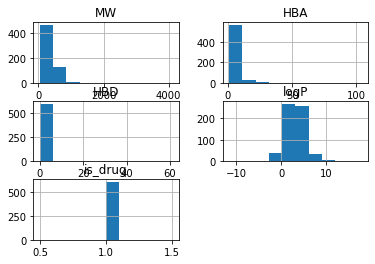

In [19]:
drug_df.hist() # dataframe자체의 hist라는 메소드를 사용!  (pandas.DataFrame.hist())

<AxesSubplot:ylabel='Frequency'>

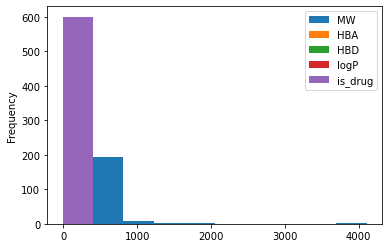

In [20]:
drug_df.plot.hist()      #얘도 별로..  #hist(여기에 몇가지 키워드를 집어넣어서 contol해야 겠다.)

array([[<AxesSubplot:title={'center':'MW'}>,
        <AxesSubplot:title={'center':'HBA'}>],
       [<AxesSubplot:title={'center':'HBD'}>,
        <AxesSubplot:title={'center':'logP'}>],
       [<AxesSubplot:title={'center':'is_drug'}>, <AxesSubplot:>]],
      dtype=object)

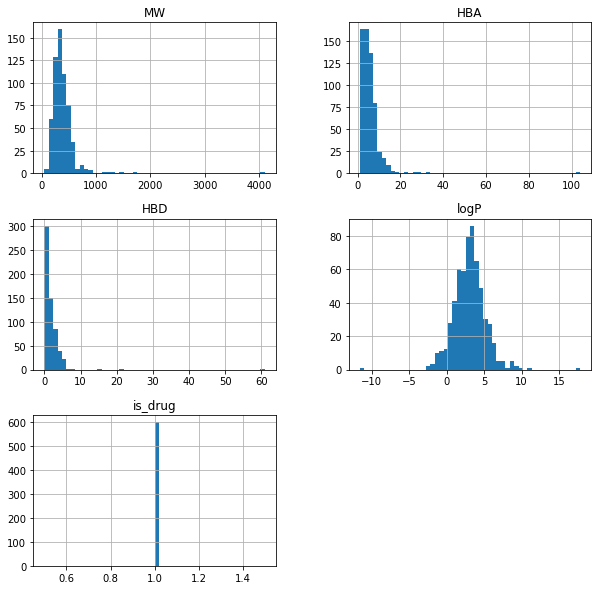

In [21]:
drug_df.hist(figsize=(10, 10), bins=50) # figsize는 그림의 크기 변환, bins는 구간의 개수. 

### Molecular weight에 대한 히스토그램만 따로 그려보자

<AxesSubplot:>

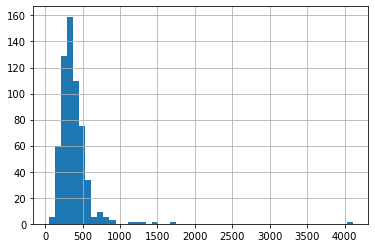

In [24]:
drug_df["MW"].hist(bins=50) # x축을 50개 구간으로 나눔. 

* X축의 구간을 설정해보자
* xlim이라는 키워드 사용. 
* DataFrame.plot.hist() 라는 메소드를 사용.  
(DataFrame.hist()보다 그림이 더 예쁘게 나오고 더 많은 옵션을 줄 수 있음.)

<AxesSubplot:ylabel='Frequency'>

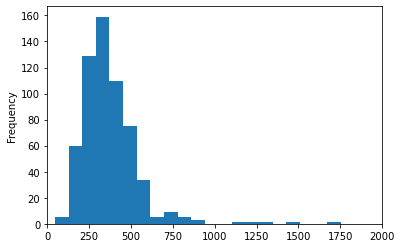

In [29]:
drug_df["MW"].plot.hist(bins=50, xlim=(0, 2000), grid=False)  # 구간을 50개로 나누고, X축을 0에서 2000까지만 그리겠다. grid(격자)는 지움. 

* 대부분 분자량이 500이하로, Linpinski's rule of five가 대체로 성립한다. 

### Hbond-acceptor에 대한 히스토그램만 따로 그려보자

<AxesSubplot:ylabel='Frequency'>

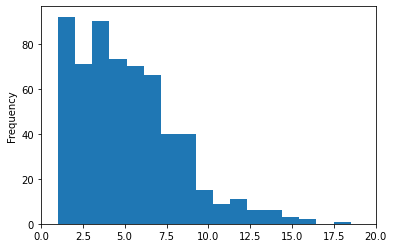

In [32]:
drug_df["HBA"].plot.hist(bins=100, xlim=(0, 20)) # 0~20까지만 그려보자. 

- 대부분 10개 이하임을 알 수 있다.

### Hbond-donor에 대한 히스토그램만 따로 그려보자

<AxesSubplot:ylabel='Frequency'>

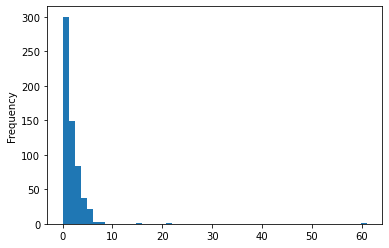

In [33]:
drug_df["HBD"].plot.hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

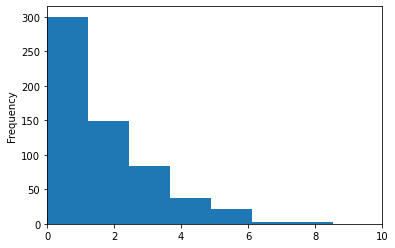

In [34]:
drug_df["HBD"].plot.hist(bins=50, xlim=(0, 10))

- 대부분 5개 이하임을 알 수 있다.

### logP 값의 분포 에 대한 히스토그램만 따로 그려보자

<AxesSubplot:ylabel='Frequency'>

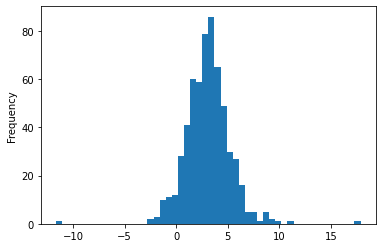

In [35]:
drug_df["logP"].plot.hist(bins=50)

- 대부분 5 이하이다.

<AxesSubplot:ylabel='Frequency'>

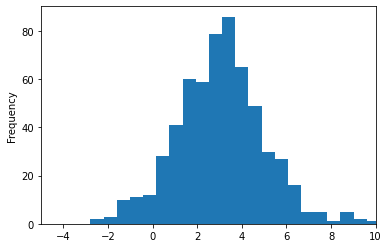

In [36]:
drug_df["logP"].plot.hist(bins=50, xlim=(-5, 10))

### 약분자의 성질의 통계치.describe() 를 확인해보자

In [37]:
drug_df.describe()

,MW,HBA,HBD,logP,is_drug
count,600.000000,600.000000,600.000000,600.000000,600.0
mean,373.048343,5.848333,1.871667,3.061503,1.0
std,225.018410,5.333799,2.967582,2.139073,0.0
min,46.041865,1.000000,0.000000,-11.627860,1.0
25%,263.188529,3.000000,1.000000,1.785350,1.0
50%,339.194677,5.000000,1.500000,3.073600,1.0
75%,443.416526,7.000000,3.000000,4.219398,1.0
max,4111.115377,104.000000,61.000000,17.853900,1.0


# [2] 약이 아닌 분자들의 property가 들어있는 dataframe을 만들자!
## 1. non_drug.smi로 분자를 읽어들이자! -> 리스트에 저장!

In [40]:
non_drugs = []
with open("non_drugs.smi") as fp:
    for l in fp:
        smiles = l.strip()
        mol = Chem.MolFromSmiles(smiles)
        if mol:   # smiles 변환에 문제가 없으면 저장. (문제가 있는 Smiles는 None으로 표시되고 False이다)
            non_drugs.append(mol)

RDKit ERROR: [11:23:24] SMILES Parse Error: syntax error while parsing: smiles
RDKit ERROR: [11:23:24] SMILES Parse Error: Failed parsing SMILES 'smiles' for input: 'smiles'
RDKit WARNING: [11:23:24] WARNING: not removing hydrogen atom without neighbors


In [41]:
non_drugs

In [42]:
len(non_drugs)

999

* 1개의 변환 에러가 난 분자를 제외한 999개의 분자를 non_drugs 리스트에 저장. 

## 2.분자로 부터 
## 분자의 특성(feature)를 뽑아내 딕셔너리에 넣은 후
## pandas DataFrame으로 변환하자!

### ◎분자들의 물성(property)을 계산한 값을 넣은 딕셔너리를 생성!

In [43]:
property = {"MW": [], "HBA": [], "HBD": [], "logP": [], "is_drug": 0} # 딕셔너리를 초기화. 
for mol in non_drugs:
    mw = CalcExactMolWt(mol) # 분자량 계산
    property["MW"].append(mw)
    
    hba = CalcNumLipinskiHBA(mol) # Hbond acceptor 개수
    property["HBA"].append(hba)
    
    hbd = CalcNumLipinskiHBD(mol) # Hbond donor 개수
    property["HBD"].append(hbd)
    
    logp, mr = CalcCrippenDescriptors(mol) # logP 계산
    property["logP"].append(logp)
    
    #property["is_drug"].append(0) # 1는 참 (True) 0은 False.

### ◎딕셔너리 ---> Pandas의 DataFrame으로 변환! 

In [44]:
non_drug_df = pd.DataFrame(property)

In [45]:
non_drug_df

,MW,HBA,HBD,logP,is_drug
0,240.220164,3,1,1.87700,0
1,281.156183,4,2,2.59610,0
2,302.073452,4,2,3.52380,0
3,282.255880,2,0,5.66270,0
4,291.231063,4,1,2.20530,0
...,...,...,...,...,...
994,674.298346,11,6,5.12654,0
995,437.004489,7,2,4.10954,0
996,375.100414,5,1,3.70520,0
997,1250.664991,14,0,19.16620,0


In [47]:
non_drug_df.describe()

,MW,HBA,HBD,logP,is_drug
count,999.000000,999.000000,999.000000,999.000000,999.0
mean,364.830076,5.250250,1.515516,3.291107,0.0
std,128.986654,2.649051,1.478473,2.063148,0.0
min,120.057515,0.000000,0.000000,-3.993900,0.0
25%,274.117944,4.000000,1.000000,2.147020,0.0
50%,341.967375,5.000000,1.000000,3.158000,0.0
75%,424.680837,7.000000,2.000000,4.334760,0.0
max,1250.664991,24.000000,16.000000,19.166200,0.0


# [3] Trainig을 위해 약o, 약x 분자를 합쳐준다!

### 두개의 표(DataFrame)를 합치자!

* pd.concat함수를 사용.
* concaternate 의 줄임말: (이어)붙이다 라는 뜻. 

In [51]:
new_df = pd.concat([drug_df, non_drug_df])

In [52]:
new_df                #두표를 그냥 이어 붙인 것이라 index는 0~599 0~998로 되어있음.

,MW,HBA,HBD,logP,is_drug
0,315.000724,4,1,2.63360,1
1,171.104799,1,1,1.89670,1
2,1343.587801,27,15,0.92454,1
3,211.110947,3,1,1.80390,1
4,204.072119,2,0,2.14610,1
...,...,...,...,...,...
994,674.298346,11,6,5.12654,0
995,437.004489,7,2,4.10954,0
996,375.100414,5,1,3.70520,0
997,1250.664991,14,0,19.16620,0


## 이제 전체 데이터셋 준비가 끝났다!

------------------
### ★ Maching Learning 기본 순서 ★
1. 전체 dataset을 불러옴 (데이터를 모음)
2. **traing set / test set으로 나눔**
3. 빈 모델을 만듦 sklearn.tree.DecisionTreeClassifier()  
4. 빈 모델에 traing set을 넣어 모델을 학습시킴 .fit()  
5. 학습된 모델에 test set을 넣어 예측시켜봄 .predict()
6. 잘 풀었나 채점해봄 .precision_score() .recall_score() . f1_score()
------------

# 이제 모델 학습을 시키자. 
* 먼저, 트레이닝 셋과 테스트 셋이 필요하다. 

* 입력을 넣어줄 값(feature,input, X)과 예측하고자 하는 목적 값(objective, output, y)을 정의해줘야 한다.  
함수에서 y=f(X)

### ◎ X (feature), y (output) 를 정의하자

In [4]:
X = new_df.iloc[:, :-1] # feature: 전체행 이면서 마지막 열 직전까지가 특성.  (index는 열에 포함x)

NameError: name 'new_df' is not defined

In [55]:
X

,MW,HBA,HBD,logP
0,315.000724,4,1,2.63360
1,171.104799,1,1,1.89670
2,1343.587801,27,15,0.92454
3,211.110947,3,1,1.80390
4,204.072119,2,0,2.14610
...,...,...,...,...
994,674.298346,11,6,5.12654
995,437.004489,7,2,4.10954
996,375.100414,5,1,3.70520
997,1250.664991,14,0,19.16620


In [56]:
y = new_df.iloc[:, -1]  # 예측하고자 하는 값.  전체행이면서 마지막 열(-1)

In [57]:
y

0      1
1      1
2      1
3      1
4      1
      ..
994    0
995    0
996    0
997    0
998    0
Name: is_drug, Length: 1599, dtype: int64

### ◎ training set과 test set을 분리하자!
* sklearn.model_selection.**train_test_split** 이라는 함수를 이용!
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
* example: **X_train, X_test, y_train, y_test** = train_test_split(**X, y,** test_size=0.33, random_state=42)


In [58]:
import sklearn.model_selection

In [59]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
X_train

,MW,HBA,HBD,logP
493,305.073805,1,1,5.17960
354,208.121178,4,0,1.16180
342,247.062677,7,0,0.53442
234,182.087769,2,1,2.13759
105,243.121906,7,3,-1.60240
...,...,...,...,...
530,227.040485,2,0,4.07010
694,449.117411,6,2,4.06930
260,351.158292,6,0,3.07648
859,422.151158,8,2,3.04150


- ↑ 80%(1279개)가 training set (연습문제) 로 뽑혔다.

In [61]:
y_train

493    1
354    1
342    1
234    0
105    0
      ..
530    0
694    0
260    0
859    0
526    0
Name: is_drug, Length: 1279, dtype: int64

- ↑ 연습문제에 해당하는 정답(output) 도 뽑혔다. 

In [62]:
X_test

,MW,HBA,HBD,logP
203,338.016057,8,5,-0.12410
124,430.061041,6,2,2.87958
350,170.105528,4,2,-0.12730
82,236.928676,3,0,1.44860
726,453.196459,6,2,1.36610
...,...,...,...,...
659,207.071785,2,1,2.77300
695,224.096106,4,2,1.23960
555,315.183444,4,2,3.33830
363,435.005545,4,1,4.02260


In [63]:
y_test

203    0
124    1
350    1
82     0
726    0
      ..
659    0
695    0
555    0
363    0
104    0
Name: is_drug, Length: 320, dtype: int64

## 여기까지가 데이터 준비

------------------
### ★ Maching Learning 기본 순서 ★
1. 전체 dataset을 불러옴 (데이터를 모음)
2. traing set / test set으로 나눔
3. **빈 모델을 만듦** RandomForestClassifier()  
4. **빈 모델에 traing set을 넣어 모델을 학습시킴** .fit()  
5. **학습된 모델에 test set을 넣어 예측시켜봄** .predict()
6. 잘 풀었나 채점해봄 .precision_score() .recall_score() . f1_score()
------------

# 여기부터 진짜 학습. 

## RandomForest 라는 모델을 사용해보자!
* https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [64]:
from sklearn.ensemble import RandomForestClassifier

### ◎ 빈 모델, 초기 모델을 하나 정의하자! **.RandomForestClassifier()**

In [78]:
my_model = RandomForestClassifier() # default parameter를 사용해서 모델을 생성. 

### ◎ 나의 모델을 학습시키자! **.fit()**
* sklearn 안의 모든 모델들은 fit() 메소드로 학습(training!)
* **X_train (문제), y_train (정답)** 을 넣어줌!
* training 이므로 변수 지정 없이 돌려주기만 하면됨.

In [66]:
my_model.fit(X_train, y_train) # X_train: 문제, y_train: 정답 을 넣어줌.

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

* 학습이 끝났다!

### ◎ 예측(시험)을 시켜보자! **.predict()**
* sklearn에서 항상 예측을 시킬 때는 predict 메소드를 쓴다!
* ※주의※ **X_test(문제)** 만 input으로 줌! - 시험보는데 정답을 주면 안되지!
* 시험 문제 푼 결과를 받아야 하기 때문에 **y_pred(예측값:제출 답안지)** 로 지정해 줘야함.

In [67]:
y_pred = my_model.predict(X_test) # X_test만 input으로 준다!

In [68]:
y_pred

array([0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,

In [69]:
len(y_pred)

320

------------------
### ★ Maching Learning 기본 순서 ★
1. 전체 dataset을 불러옴 (데이터를 모음)
2. traing set / test set으로 나눔
3. 빈 모델을 만듦 RandomForestClassifier()  
4. 빈 모델에 traing set을 넣어 모델을 학습시킴 .fit()  
5. 학습된 모델에 test set을 넣어 예측시켜봄 .predict()
6. **잘 풀었나 채점해봄** .precision_score() .recall_score() . f1_score()
------------

### ◎ 채점을 해보자! **precision_score(), recall_score(), f1_score()**
* sklearn.metrics안에 있는 precision_score, recall_score, f1_score를 이용하자!
* **y_test(정답), y_pred(예측값:제출 답안지)** 을 넣어줌.

In [72]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [73]:
precision_score(y_test, y_pred) # 정확도를 계산. y_true, y_pred를 입력인자로 준다. 

0.5760869565217391

* ↑ 정확도가 57.6%가 나왔다!
* 우리의 입력데이터에서 600개가 약, 999개가 약이 아니었으므로, 랜덤하게 찍으면 6/1600 = 0.375 정도의 정확도가 예상된다. 
* 그렇기 때문에 랜덤하게 찍는 것 보다는 정확하다. 

In [75]:
recall_score(y_test, y_pred) # 재현율

0.4108527131782946

* ↑ 실제 약 분자중에서 41%만 맞췄다. (실제 약중 60%는 약이 아니라고 제출했다.)

In [76]:
f1_score(y_test, y_pred)

0.4796380090497738

* ↑ 0.48 정도의 F1-score를 가진다. 

# 여기까지 첫번째 화학 예측 모델 (QSAR) 모델을 만들었다! 
---

# <span style="color:blue">14주차(1) Random Forest - Hyper parameter tuning, feature importance</span>
Discriminating drugs and non-drugs using RF and hyperparameter optimization / feature importance

------------------
### ★ Maching Learning 기본 순서 ★
1. 전체 dataset을 불러옴 (데이터를 모음)
2. traing set / test set으로 나눔
3. **빈 모델을 만듦** RandomForestClassifier()  <span style="color:red">←여기부터 다시 다른 모델 생성</span>
4. **빈 모델에 traing set을 넣어 모델을 학습시킴** .fit()  
5. **학습된 모델에 test set을 넣어 예측시켜봄** .predict()
6. **잘 풀었나 채점해봄** .precision_score() .recall_score() . f1_score()
------------

# Hyperparameter optimization

## 모델의 하이퍼 파라미터를 바꾸어 가면서 모델의 성능을 최적화 하자!
모델의 성능을 높이는 하이퍼 파라미터를 찾는데는 특별한 이론이 존재하지 않는다. 이것 저것 넣어가면서 노가다 필수.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
Parameter  

* 테스트 해볼 하이퍼 파라미터(옵션):
1. n_estimatorn :트리의 개수 (밑으로 몇번까지 나눈 것인가)
2. max_depth : 트리의 최대 깊이
3. min_samples_split : 최소 몇개일 때 쪼갤것 인가 (최소 개수 미만이면 자르지 마라)
4. min_samples_leaf : 한 노드 안의 최소 데이터 개수 (몇개가 있으면 그만 쪼갤 것인가)  

### Version2
##### ◎ 빈 모델 생성

In [80]:
# 파라미터를 넣은 빈껍데기 생성.
my_model_v2 = RandomForestClassifier(n_estimators=200) # n_estimator의 기본 값은 100. 

In [81]:
print(my_model_v2)     #내가 define한 모델의 옵션들을 보여줌

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


### 학습을 시키자!
* fit method 사용!

##### ◎ 빈 모델에 trainig set 넣어 학습시킴

In [82]:
my_model_v2.fit(X_train, y_train) # 학습

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### 학습이 잘 되었는지 확인! 테스트를 해보자!
* predict() 메소드를 이용해서 예측. 

##### ◎ 학습된 모델에 test set을 넣어 예측시켜봄

In [83]:
y_pred = my_model_v2.predict(X_test)

In [84]:
print(y_pred)

[0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 0 1 0 1 0 0 1 1 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 1
 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0
 0 0 0 1 1 0 0 1 0 0 0 1 1 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0
 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 1 0 0 1 1
 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 1 0 0
 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 1 0 0 1 0 0 0 0 0 1 0
 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 1 1 0 1 1 0 1 0 0 0 1 0 0 0 1
 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0]


In [85]:
X_test

,MW,HBA,HBD,logP
203,338.016057,8,5,-0.12410
124,430.061041,6,2,2.87958
350,170.105528,4,2,-0.12730
82,236.928676,3,0,1.44860
726,453.196459,6,2,1.36610
...,...,...,...,...
659,207.071785,2,1,2.77300
695,224.096106,4,2,1.23960
555,315.183444,4,2,3.33830
363,435.005545,4,1,4.02260


### 채점을 해보자!

##### ◎잘 풀었나 채점해봄

In [86]:
precision_score(y_test, y_pred) # 정확도를 계산. y_true, y_pred를 입력인자로 준다. 

0.5824175824175825

In [87]:
recall_score(y_test, y_pred) # 재현율

0.4108527131782946

In [88]:
f1_score(y_test, y_pred) # F1-score 계산. 

0.48181818181818187

* ↑ 지난 번 모델의 F1-score (0.47...)보다 조금 좋아졌다. 

### Version3 새로운 하이퍼 파라미터 테스트

In [89]:
my_model_v3 = RandomForestClassifier(n_estimators=500, max_depth = 5, min_samples_split = 5)

In [90]:
my_model_v3.fit(X_train, y_train) # 학습

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [91]:
y_pred = my_model_v3.predict(X_test) # 테스트 문제 풀기. 

In [92]:
print(y_pred)

[0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1
 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0
 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [93]:
precision_score(y_test, y_pred)# 실제 값(정답, y_test)을 먼저 넣어줌. 

0.6206896551724138

In [94]:
recall_score(y_test, y_pred) # 재현율

0.13953488372093023

In [95]:
f1_score(y_test, y_pred)

0.22784810126582278

- ↑ 더 안좋은 모델이 되었다.

### Version4 다른 모델을 한 번만 더

In [96]:
my_model_v4 = RandomForestClassifier(n_estimators=400, random_state=487)  #random_state에 아무 숫자 하나 쓰고 항상 그 옵션을 부여하면 똑같은 결과가 나올 것이고, 부여하지 않으면 매번 다른 값을 얻게 될 것.

In [97]:
my_model_v4.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [99]:
y_pred = my_model_v4.predict(X_test)

In [100]:
precision_score(y_test, y_pred)

0.5698924731182796

In [101]:
recall_score(y_test, y_pred)

0.4108527131782946

In [102]:
f1_score(y_test, y_pred)

0.47747747747747754

- ↑ 더 안좋은 모델이 되었다.

## 숙제: 하이퍼 파라미터를 바꾸면서 f1_score 가 0.481 을 넘는 모델이 있는지 한 번 찾아보세요~

# Feature Importance 분석
이 모델이 feature들 중에서 뭘 가장 중요하게 참고하고 있는지 알아봄.;

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html  
Attributes (학습이 끝나고나면 여러가지 속성을 가지고 있음)  
여기서 다룰 것은 --->  모델명 **.feature_importances_**

현재 이 노트북에서 사용하고 있는 Feature 는 4가지: 

    1. MW
    2. H-Bond Acceptor 개수
    3. H-Bond donor 개수
    4. logP 값. 

In [103]:
X_train

,MW,HBA,HBD,logP
493,305.073805,1,1,5.17960
354,208.121178,4,0,1.16180
342,247.062677,7,0,0.53442
234,182.087769,2,1,2.13759
105,243.121906,7,3,-1.60240
...,...,...,...,...
530,227.040485,2,0,4.07010
694,449.117411,6,2,4.06930
260,351.158292,6,0,3.07648
859,422.151158,8,2,3.04150


In [104]:
print(my_model_v4.feature_importances_)

[0.40852432 0.12379072 0.09466798 0.37301698]


* ↑ 4개의 feature의 importance(중요도)를 정량화한 지표. 

* 다시 말해, Drug / Drug이 아닌 분자를 구별할 때, MW이 0.408 만큼 중요한 역할을 했고,  
H-bond acceptor 개수가 0.124, H-bond donor 개수가 0.094, logP 값이 0.373 만큼의 역할을 했다. 
* 즉, Drug/Non-Drug을 구별할 때,  
MW가 가장 중요. 두 번째, logP 값, 번째가 수소결합 받개의 개수, 네번째가 수소결합 주개의 개수. 

In [107]:
print(my_model_v3.feature_importances_)

[0.40591372 0.18685081 0.16288988 0.24434559]


In [108]:
print(my_model_v2.feature_importances_)

[0.40445491 0.12526646 0.09520563 0.37507299]
